In [4]:
import numpy as np
import torch
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
import joblib
import statistics
import time
from utils import calculate_metric
import matplotlib.pyplot as plt
from pathlib import Path
import gpytorch
import os
import shap
from sklearn.metrics import mean_squared_error
import optuna

# Import our ExactGP implementation
from exact_gaussian_process import ExactGaussianProcess

In [5]:
# Set random seeds
np.random.seed(0)
torch.manual_seed(0)

In [6]:
# Configuration
DATA_FOLDER = "../data"
TRAIN_FEATURES = DATA_FOLDER + '/train_features2.xlsx'
TRAIN_LABELS = DATA_FOLDER + "/train_labels2.xlsx"
TEST_FEATURES = DATA_FOLDER + "/test_features2.xlsx"
TEST_LABELS = DATA_FOLDER + "/test_labels2.xlsx"

MODEL_PATH = '../output/ExactGP'
PROJECT_NAME = "run/ExactGP"
TRAINING_OUTPUT_FILE = '../output/train_predictions.xlsx'
TEST_OUTPUT_FILE = '../output/test_predictions.xlsx'
OOF_PREDICTIONS_FILE = '../output/oof_predictions.xlsx'
SHEET_NAME = "ExactGP"
OUTPUT_FILE = MODEL_PATH + '/ExactGP.pkl'

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
# create path
output_dir = Path(MODEL_PATH)
output_dir.mkdir(parents=True, exist_ok=True)

In [8]:
train_features = pd.read_excel(TRAIN_FEATURES)
train_labels = pd.read_excel(TRAIN_LABELS)
test_features = pd.read_excel(TEST_FEATURES)
test_labels = pd.read_excel(TEST_LABELS)

In [9]:
test_features.head()

,coupon rate,SP500 MD,Average daily 1-year SP500 return,Ratio to MA,US Corporate Bond Yield Spread,US Corporate Bond Yield Spread(3-5 year),US Corporate Bond Yield Spread(5-7 year),US Corporate Bond Yield Spread(7-10 year),US Corporate Bond Yield Spread(10+ year),US Generic Govt 3 Month Yield,...,event_type_subcategory_sum_Missing Coupon payment only,event_type_subcategory_sum_Missing Interest payment,event_type_subcategory_sum_Missing Loan payment,event_type_subcategory_sum_Missing Principal payment,event_type_subcategory_sum_Others,event_type_subcategory_sum_Pre-Negotiated Chapter 11,event_type_subcategory_sum_Protection,event_type_subcategory_sum_Receivership,event_type_subcategory_sum_Rehabilitation,event_type_subcategory_sum_Restructuring
0,3.125,-122.39680,-0.001341,1.116103,396.408936,399.031738,455.0625,383.612488,341.675812,0.1734,...,False,False,False,False,False,False,False,False,False,False
1,15.000,156.01912,0.000790,6.372588,107.083778,76.414360,118.2482,113.403519,147.756165,0.0253,...,False,False,False,False,False,False,False,False,False,False
2,0.000,-451.10824,-0.002033,43.914617,637.607544,689.770996,683.3611,589.969666,529.166992,0.0406,...,False,False,False,True,False,False,False,False,False,False
3,5.875,-751.22120,-0.000435,74.783398,153.653778,129.425842,158.3252,172.708054,187.147980,1.4908,...,False,False,False,False,False,False,False,False,False,False
4,10.000,55.69036,0.000712,-28.522133,152.290619,148.385330,222.1811,142.140915,159.624313,0.0763,...,False,False,False,False,False,False,False,False,False,False


In [11]:
feature_list = train_features.columns
# category_feature_key = ['currency', 'seniorioty_adj', 'domicile_country',	'exchange_country',	'Industry_sector',	'Industry_group',	'Industry_subgroup', 'event_type',
#                  'event_type_subcategory_sum', 'defaulted_in_last_6_months']
# category_features = [i for i in feature_list if any(sub in i for sub in category_feature_key)]
category_features = train_features.select_dtypes(include=['int', 'bool']).columns
non_category_features = [i for i in feature_list if i not in category_features]

print(len(category_features))
print(len(non_category_features))

164
153


In [24]:
# Define a function to tune hyperparameters using Optuna
def tune_hyperparameters_optuna(X, y, non_category_features, n_trials=20, n_splits=5, random_state=42):
    # Initialize K-fold cross-validation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    def objective(trial):
        # Define hyperparameters to tune
        num_epochs = trial.suggest_int('num_epochs', 100, 2000, step=100)
        learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True)
        
        fold_rmses = []
        
        # Perform k-fold cross-validation
        for train_idx, val_idx in kf.split(X):
            X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
            y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
            
            # Initialize and train model with current parameters
            model = ExactGaussianProcess(
                non_category_features=non_category_features,
                num_epochs=num_epochs,
                learning_rate=learning_rate
            )
            
            # Train the model
            model.fit(X_train_fold, y_train_fold.values)
            
            # Make predictions
            val_pred, _ = model.predict(X_val_fold)
            
            # Calculate RMSE
            rmse = np.sqrt(mean_squared_error(y_val_fold.values.ravel(), val_pred.ravel()))
            fold_rmses.append(rmse)
        
        # Return average RMSE across folds
        return np.mean(fold_rmses)
    
    # Create a study object and optimize the objective function
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)
    
    # Get best parameters
    best_params = study.best_params
    best_rmse = study.best_value
    
    print("\nBest Parameters:")
    for param, value in best_params.items():
        print(f"{param}: {value}")
    print(f"Best RMSE: {best_rmse:.4f}")
    
    # Plot optimization history
    try:
        optuna.visualization.plot_optimization_history(study)
        optuna.visualization.plot_param_importances(study)
    except:
        print("Visualization could not be displayed in notebook environment")
    
    return best_params

# Uncomment the following line to run hyperparameter tuning with Optuna
best_params = tune_hyperparameters_optuna(train_features, train_labels, non_category_features, 50)



[I 2025-04-10 11:37:11,756] A new study created in memory with name: no-name-31536d34-09af-4682-982e-d02a751880c8
[I 2025-04-10 11:41:49,816] Trial 0 finished with value: 0.2354517393363961 and parameters: {'num_epochs': 1400, 'learning_rate': 0.04212225594086428}. Best is trial 0 with value: 0.2354517393363961.
[I 2025-04-10 11:44:12,568] Trial 1 finished with value: 0.23211595343409144 and parameters: {'num_epochs': 800, 'learning_rate': 0.0062833446868646005}. Best is trial 1 with value: 0.23211595343409144.
[I 2025-04-10 11:44:31,295] Trial 2 finished with value: 0.23826892525031043 and parameters: {'num_epochs': 100, 'learning_rate': 0.02548182277544917}. Best is trial 1 with value: 0.23211595343409144.
[I 2025-04-10 11:46:15,763] Trial 3 finished with value: 0.26773836921192834 and parameters: {'num_epochs': 600, 'learning_rate': 0.00019391802680308545}. Best is trial 1 with value: 0.23211595343409144.
[I 2025-04-10 11:50:04,264] Trial 4 finished with value: 0.2638655896236233 an


Best Parameters:
num_epochs: 1600
learning_rate: 0.005927505683122846
Best RMSE: 0.2310


RUNNING THE MODEL

In [12]:
best_params = {"num_epochs" : 1600,
"learning_rate": 0.005927505683122846}

In [26]:
# Initialize and train the model
model = ExactGaussianProcess(non_category_features=non_category_features, **best_params)

start_time = time.time()

model.fit(train_features, train_labels.values)

elapsed_time = time.time() - start_time
print(f"Training time: {elapsed_time:.3f} seconds")

In [27]:
# Make predictions
train_pred, train_std = model.predict(train_features, return_std=True)
test_pred, test_std = model.predict(test_features, return_std=True)

# Calculate metrics
print("Training Metrics:")

mae, mape, rmse, rsqr = calculate_metric(train_labels.values.ravel(), train_pred.ravel())
print(f"Train average mean absolute error: {mae}")
print(f"Train average mean absolute percentage error: {mape}")
print(f"Train average root mean squared error: {rmse}")
print(f"Train average R2: {rsqr}")

print("\nTest Metrics:")
mae, mape, rmse, rsqr = calculate_metric(test_labels.values.ravel(), test_pred.ravel())
print(f"Val average mean absolute error: {mae}")
print(f"Val average mean absolute percentage error: {mape}")
print(f"Val average root mean squared error: {rmse}")
print(f"Val average R2: {rsqr}")

Training Metrics:
Train average mean absolute error: 0.04873769805187833
Train average mean absolute percentage error: 15.633757606841314
Train average root mean squared error: 0.08179979354582659
Train average R2: 0.9237544013621777

Test Metrics:
Val average mean absolute error: 0.1453389514057312
Val average mean absolute percentage error: 47.02816898668601
Val average root mean squared error: 0.21935166256193853
Val average R2: 0.2894552921378023


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gpytorch/models/exact_gp.py:296: GPInputWarning:

The input matches the stored training data. Did you forget to call model.train()?



In [28]:
# Get model parameters
params = model.get_params()
print("Model Parameters:")
for param_name, value in params.items():
    print(f"{param_name}:")
    print(value)

Model Parameters:
constant_mean:
0.12481071799993515
lengthscales:
[[ 0.8989417   7.2328224   8.152617   10.393556    9.613992    9.841023
   9.237952    9.192711    8.818711    9.580505    9.863122    9.656941
   9.789793    9.582011    9.724997    9.703408    9.96344     8.339609
   8.51873     8.870724    7.1676717  10.32534    10.093473    9.242993
  10.438042   10.136112    9.585501    9.453995    9.351373    8.8839655
  10.272917   10.060711    9.10042     6.4408345   5.447581    6.6388216
   8.832192    8.53376     8.587531    7.5783415   8.193796    8.237363
   8.690532    9.47924     6.7371798   8.546481    5.944167    8.095341
   7.569961    4.285811    9.645102    9.987992    9.861657    9.969114
   9.36232     7.6502523   8.924193   10.5929785   8.804503    9.620949
  10.260692   12.037952    9.09301     9.580154    8.8321495   2.9972281
   4.2662253   9.345316    7.526826    8.021349   10.309656   10.308337
  10.29651     9.374347    6.5388865   8.497361    8.55109     8.8

In [29]:
# save train predictions
train_predictions_df = pd.DataFrame({"predictions": train_pred})
with pd.ExcelWriter(TRAINING_OUTPUT_FILE, mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
    # Write the new DataFrame to a new sheet
    train_predictions_df.to_excel(writer, sheet_name=SHEET_NAME, index=False)
    
# save test predictions
test_predictions_df = pd.DataFrame({"predictions": test_pred})
with pd.ExcelWriter(TEST_OUTPUT_FILE, mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
    # Write the new DataFrame to a new sheet
    test_predictions_df.to_excel(writer, sheet_name=SHEET_NAME, index=False)

# Save the best model
joblib.dump(model, OUTPUT_FILE)

['../output/ExactGP/ExactGP.pkl']

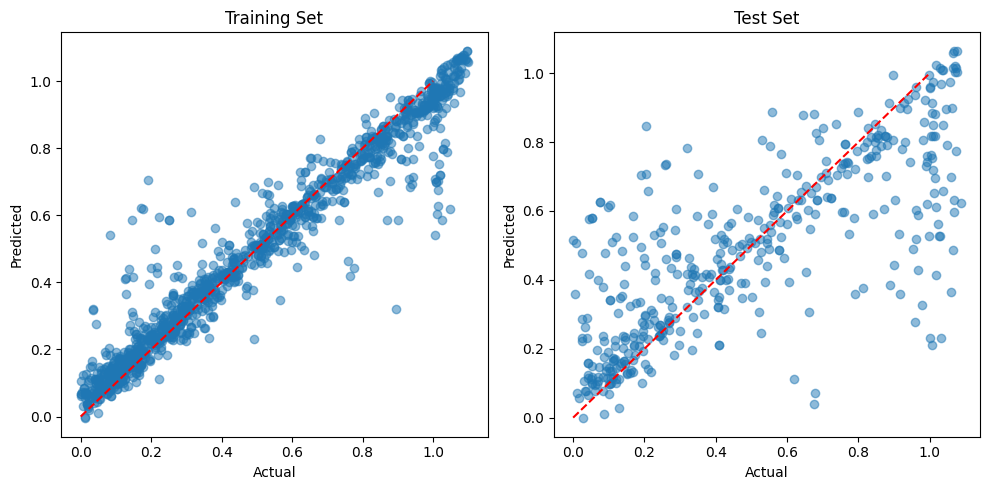

In [30]:
# Plotting actual vs predicted values
plt.figure(figsize=(10, 5))

# Training data
plt.subplot(1, 2, 1)
plt.scatter(train_labels.values, train_pred, alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Training Set')

# Test data
plt.subplot(1, 2, 2)
plt.scatter(test_labels.values, test_pred, alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Test Set')

plt.tight_layout()
plt.show()

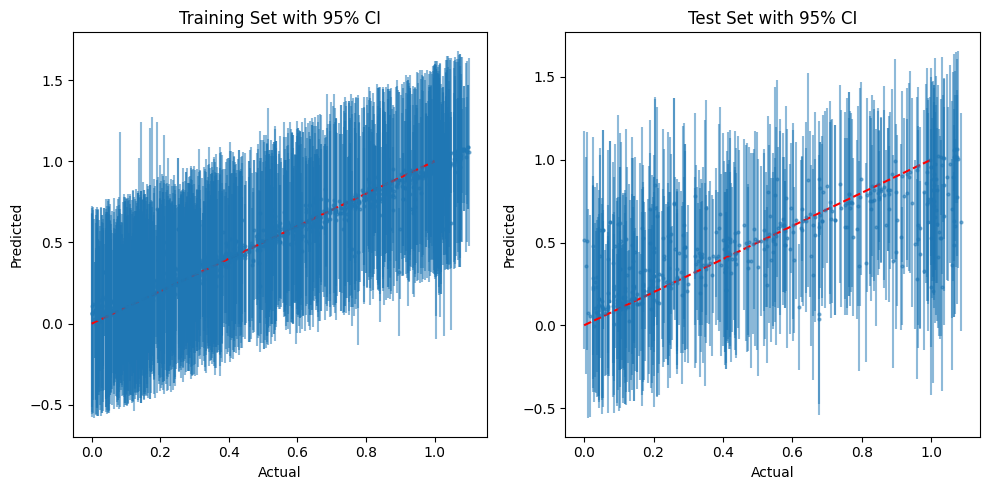

In [31]:
# Plot uncertainty
plt.figure(figsize=(10, 5))

# Training data
plt.subplot(1, 2, 1)
plt.errorbar(train_labels.values, train_pred, yerr=2*train_std, fmt='o', alpha=0.5, markersize=2)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Training Set with 95% CI')

# Test data
plt.subplot(1, 2, 2)
plt.errorbar(test_labels.values, test_pred, yerr=2*test_std, fmt='o', alpha=0.5, markersize=2)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Test Set with 95% CI')

plt.tight_layout()
plt.show()

Feature importance

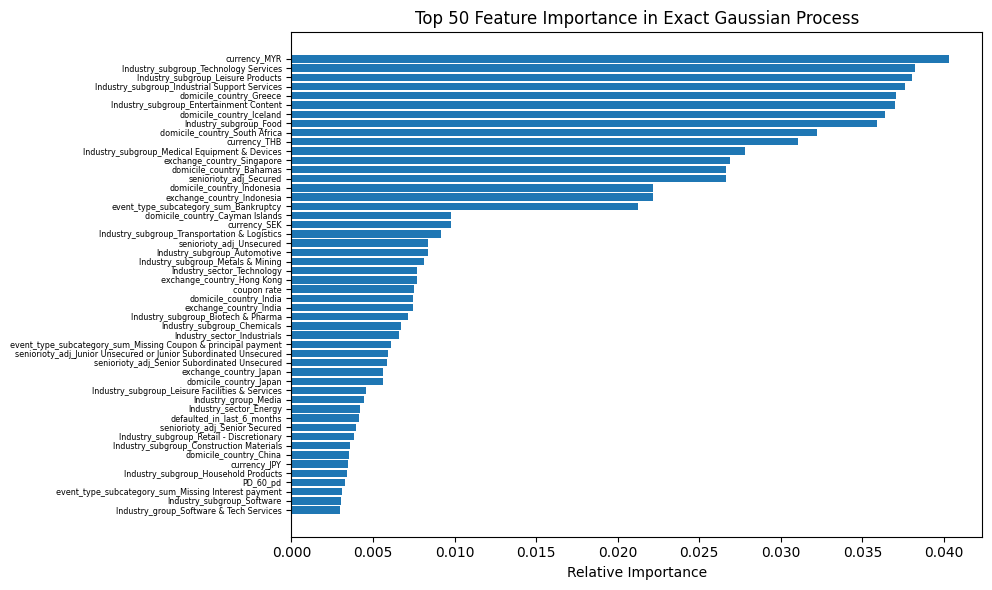

Top 10 most important features:
                                           Feature  Importance
164                                   currency_MYR    0.040328
293          Industry_subgroup_Technology Services    0.038195
276             Industry_subgroup_Leisure Products    0.038037
273  Industry_subgroup_Industrial Support Services    0.037587
187                        domicile_country_Greece    0.037041
264        Industry_subgroup_Entertainment Content    0.037016
189                       domicile_country_Iceland    0.036364
265                         Industry_subgroup_Food    0.035916
199                  domicile_country_South Africa    0.032243
168                                   currency_THB    0.031074


In [ ]:
# Feature Importance Analysis for Exact Gaussian Process

# For GP models, we can interpret feature importance from the lengthscales
# of the RBF kernel - smaller lengthscales indicate more important features
params = model.get_params()

# Extract lengthscales and feature names
if 'lengthscales' in params:
    lengthscales = params['lengthscales'].flatten()
    
    # If lengthscales is multi-dimensional, we can interpret feature importance
    if len(lengthscales) == train_features.shape[1]:
        # Inverse of lengthscale can be interpreted as feature importance
        # (smaller lengthscale = more important feature)
        importance = 1.0 / lengthscales
        
        # Normalize to sum to 1
        importance = importance / importance.sum()
        
        # Create DataFrame for visualization
        feature_importance = pd.DataFrame({
            'Feature': train_features.columns,
            'Importance': importance
        }).sort_values('Importance', ascending=False)
        
        # Plot top 20 most important features
        plt.figure(figsize=(12, 6))
        top_features = feature_importance.head(50)
        plt.barh(top_features['Feature'], top_features['Importance'])
        plt.xlabel('Relative Importance')
        plt.title('Top 50 Feature Importance in Exact Gaussian Process')
        plt.gca().invert_yaxis()  # Display most important at the top
        plt.tight_layout()
        plt.yticks(fontsize='xx-small')
        plt.savefig(os.path.join(MODEL_PATH,'feature_importance.png'))
        plt.show()
        
        # Print top 10 features with their importance scores
        print("Top 10 most important features:")
        print(feature_importance.head(10))
    else:
        print(f"Lengthscales dimension ({len(lengthscales)}) doesn't match feature count ({features.shape[1]})")
        print("Cannot calculate per-feature importance")
else:
    print("Lengthscales not found in model parameters. Cannot calculate feature importance.")
    print("Available parameters:", list(params.keys()))


SHAP on training set

In [1]:

# Create a function to get model predictions (needed for SHAP)
def model_predict(X):
    return model.predict(X, return_std=False)[0]

# Create a SHAP explainer
print("Creating SHAP explainer...")
# Use a subset of training data as background for computational efficiency
background = shap.sample(train_features.values, min(1000, len(train_features)))
explainer = shap.KernelExplainer(model_predict, background)

# Calculate SHAP values on a subset of the training data for visualization
print("Calculating SHAP values (this may take a while)...")
sample_size = min(1000, len(train_features))  # Limit sample size for computational efficiency
sample_indices = np.random.choice(len(train_features), sample_size, replace=False)
sample_data = train_features.iloc[sample_indices].values
shap_values = explainer.shap_values(sample_data)

# Create summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, sample_data, feature_names=train_features.columns, show=False)
plt.title("SHAP Feature Importance for Exact Gaussian Process")
plt.tight_layout()
plt.savefig(os.path.join(MODEL_PATH, 'training_shap_summary.png'))
plt.show()

# Create bar plot of mean absolute SHAP values
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, sample_data, feature_names=train_features.columns, plot_type="bar", show=False)
plt.title("Mean Impact on Model Output Magnitude")
plt.tight_layout()
plt.savefig(os.path.join(MODEL_PATH, 'training_shap_bar.png'))
plt.show()

# Compare top SHAP features with lengthscale-based importance
if 'lengthscales' in params and len(lengthscales) == train_features.shape[1]:
    # Get top 10 features by SHAP values
    shap_importance = np.abs(shap_values).mean(0)
    shap_importance_df = pd.DataFrame({
        'Feature': train_features.columns,
        'SHAP_Importance': shap_importance
    }).sort_values('SHAP_Importance', ascending=False)
    
    print("\nTop 10 features by SHAP importance:")
    print(shap_importance_df.head(10))
    
    # Compare with lengthscale-based importance
    print("\nComparison between SHAP and lengthscale-based importance:")
    comparison = pd.merge(
        feature_importance[['Feature', 'Importance']].rename(columns={'Importance': 'Lengthscale_Importance'}),
        shap_importance_df[['Feature', 'SHAP_Importance']],
        on='Feature'
    )
    print(comparison.sort_values('SHAP_Importance', ascending=False).head(10))


Creating SHAP explainer...


NameError: name 'shap' is not defined

5-FOLD CV

In [13]:
features = pd.concat([train_features, test_features], axis=0, ignore_index=True)
features

,coupon rate,SP500 MD,Average daily 1-year SP500 return,Ratio to MA,US Corporate Bond Yield Spread,US Corporate Bond Yield Spread(3-5 year),US Corporate Bond Yield Spread(5-7 year),US Corporate Bond Yield Spread(7-10 year),US Corporate Bond Yield Spread(10+ year),US Generic Govt 3 Month Yield,...,event_type_subcategory_sum_Missing Coupon payment only,event_type_subcategory_sum_Missing Interest payment,event_type_subcategory_sum_Missing Loan payment,event_type_subcategory_sum_Missing Principal payment,event_type_subcategory_sum_Others,event_type_subcategory_sum_Pre-Negotiated Chapter 11,event_type_subcategory_sum_Protection,event_type_subcategory_sum_Receivership,event_type_subcategory_sum_Rehabilitation,event_type_subcategory_sum_Restructuring
0,7.500,-117.46020,-0.000189,125.407139,177.213028,134.012054,198.8153,191.364395,223.346344,0.1983,...,True,False,False,False,False,False,False,False,False,False
1,6.000,166.38276,0.000768,-4.603446,101.613617,77.032829,123.3998,105.932022,139.111115,0.0355,...,False,False,False,False,False,False,False,False,False,False
2,11.000,119.85752,0.000678,-11.950380,104.545959,77.416649,129.4317,111.818001,139.717407,0.0101,...,False,False,False,False,False,False,False,False,False,False
3,9.125,653.51208,0.001638,-2.494861,90.736633,64.654129,95.3731,92.141212,121.666237,0.0152,...,False,False,False,False,False,False,False,False,False,False
4,9.250,231.89472,0.000664,4.823413,98.533821,68.759308,93.4174,107.424469,139.741165,1.2865,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1720,3.250,147.33344,0.000556,3.538252,128.976395,95.360374,138.8445,138.946106,172.733887,0.0000,...,False,False,False,False,False,False,False,False,False,False
1721,10.000,175.31656,0.000554,-4.067337,121.170998,92.879501,123.2500,131.104904,162.916901,0.7516,...,False,True,False,False,False,False,False,False,False,False
1722,7.450,315.81748,0.000747,8.604100,126.786606,89.018188,114.9728,131.522430,171.701096,0.0864,...,False,False,False,False,False,False,False,False,False,False
1723,0.500,31.75120,-0.000157,-4.373852,126.595230,105.460007,121.6212,147.382416,163.772141,4.8375,...,False,False,False,False,False,False,False,False,False,False


In [14]:
labels = pd.concat([train_labels, test_labels], axis=0, ignore_index=True)
labels

,rr1_30
0,0.082481
1,0.378845
2,0.836149
3,0.987208
4,1.021458
...,...
1720,0.471411
1721,0.823750
1722,0.241612
1723,0.762054


In [15]:

# Set up 5-fold cross validation
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Initialize arrays to store results
val_mae = []
val_mape = []
val_rmse = []
val_rsqr = []

print(f"Performing {n_folds}-fold cross-validation...")

# Loop through each fold
for fold, (train_idx, test_idx) in enumerate(kf.split(features)):
    print(f"\nFold {fold+1}/{n_folds}")
    
    # Split data
    X_train_fold, X_test_fold = features.iloc[train_idx], features.iloc[test_idx]
    y_train_fold, y_test_fold = labels.iloc[train_idx], labels.iloc[test_idx]
    
    # Train model
    start_time = time.time()
    gp = ExactGaussianProcess(non_category_features=non_category_features, **best_params)
    gp.fit(X_train_fold, y_train_fold.values)

    
    # Make predictions
    test_pred_fold, test_std_fold = gp.predict(X_test_fold, return_std=True)
    
    # Calculate metrics
    mae, mape, rmse, rsqr = calculate_metric(y_test_fold.values.ravel(), test_pred_fold.ravel())
    val_mae.append(mae)
    val_mape.append(mape)
    val_rmse.append(rmse)
    val_rsqr.append(rsqr)

Performing 5-fold cross-validation...

Fold 1/5

Fold 2/5

Fold 3/5

Fold 4/5

Fold 5/5


In [16]:
print(f"Test average mean absolute error: {statistics.mean(val_mae)}")
print(f"Test average mean absolute percentage error: {statistics.mean(val_mape)}")
print(f"Test average root mean squared error: {statistics.mean(val_rmse)}")
print(f"Test average R2: {statistics.mean(val_rsqr)}")

Test average mean absolute error: 0.13744661831572844
Test average mean absolute percentage error: 52.09207278964187
Test average root mean squared error: 0.2107473210214649
Test average R2: 0.3606927866994012


In [17]:
val_rmse

[0.2073475562456061,
 0.21502037715009906,
 0.2206538289836762,
 0.19514087682945888,
 0.21557396589848427]

In [18]:
val_rsqr

[0.3842248970566431,
 0.32623214829946623,
 0.21142212989622444,
 0.45199081388503815,
 0.42959394435963405]

SAVING OUT-OF-PREDICTION RESULTS

In [ ]:
# Set up 5-fold cross validation
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Initialize arrays to store results
val_mae = []
val_mape = []
val_rmse = []
val_rsqr = []
oof_predictions = np.zeros(train_labels.shape[0])

print(f"Performing {n_folds}-fold cross-validation...")

# Loop through each fold
for fold, (train_idx, test_idx) in enumerate(kf.split(train_features)):
    print(f"\nFold {fold+1}/{n_folds}")
    
    # Split data
    X_train_fold, X_test_fold = train_features.iloc[train_idx], train_features.iloc[test_idx]
    y_train_fold, y_test_fold = train_labels.iloc[train_idx], train_labels.iloc[test_idx]
    
    # Train model
    start_time = time.time()
    gp = ExactGaussianProcess(non_category_features=non_category_features, **best_params)
    gp.fit(X_train_fold, y_train_fold.values)

    
    # Make predictions
    test_pred_fold, test_std_fold = gp.predict(X_test_fold, return_std=True)
    oof_predictions[test_idx] = test_pred_fold.ravel()
    
    # Calculate metrics
    mae, mape, rmse, rsqr = calculate_metric(y_test_fold.values.ravel(), test_pred_fold.ravel())
    val_mae.append(mae)
    val_mape.append(mape)
    val_rmse.append(rmse)
    val_rsqr.append(rsqr)

Performing 5-fold cross-validation...

Fold 1/5

Fold 2/5


In [ ]:
oof_predictions_df = pd.DataFrame({"predictions": oof_predictions.ravel()})
with pd.ExcelWriter(OOF_PREDICTIONS_FILE, mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
    # Write the new DataFrame to a new sheet
    oof_predictions_df.to_excel(writer, sheet_name=SHEET_NAME, index=False)